gpt-4o-mini
 the system should start with the supervisor asking the agitated agent whats wrong, the agitated agent should then respond to that based on their system prompt, the supervisor should then decide whether the agitated agent needs emotional support or a logical solution ot their problem, in the first case the emotional agent should be the one to respond, in the second the logical agent. the agitated agent should then respond to the chosen agent and the supervisor should decide whether the agitated agents problem was solved or if they need further help, in that case it once again decides whether the emotional or logical agent should respond, this loop continues until the problem is solved

In [5]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing_extensions import Literal
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState, StateGraph
from langgraph.types import Command
from IPython.display import Image, display
from colorama import Fore, Back, Style

load_dotenv()

model = ChatOpenAI(model="gpt-4o-mini", max_tokens=200, temperature=0.5, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0)

def flip_ai_human_roles_messages(messages: list[dict[str, str]]) -> list[dict[str, str]]:
    flipped_messages = []
    for message in messages:
        if message["role"] == "ai":
            flipped_messages.append({"role": "human", "content": message["content"]})
        elif message["role"] == "human":
            flipped_messages.append({"role": "ai", "content": message["content"]})
    return flipped_messages

def supervisor_agent(state: MessagesState):
    messages = state.get("messages", [])
    
    if not messages:
        messages.append({"role": "ai", "content": "Please tell me what's bothering you."})
        print(Fore.CYAN + "-"*50)
        print("Supervisor \n\nPlease tell me what's bothering you.")
        print("-"*50)
        return Command(
            goto="agitated_agent",
            update={"messages": messages}
        )
    
    # Find the latest user message
    user_messages = [msg for msg in messages if msg["role"] == "human"]
    last_user_message = user_messages[-1]["content"]
    
    # Analyze if problem is solved
    problem_solved_prompt = """Based on the user's last response, determine if their problem has been 
                                solved or whether they still need emotional support or a logical solution
                                to their problem. Respond with a single word: 'yes' or 'no'. If the user 
                                poses a question in their last response that is not rhetorical your response should be 'no'."""
    
    solved_assessment = model.invoke([
        {"role": "system", "content": problem_solved_prompt},
        {"role": "human", "content": last_user_message}
    ]).content.strip().lower()

    print(Fore.CYAN + "-"*50)
    print(f"Supervisor - Problem Solved Decision: {solved_assessment}")
    print("-"*50)
    
    if solved_assessment == 'yes':
        return Command(goto="__end__", update={"messages": messages})

    # Determine next agent
    agent_selection_prompt = """Based on the user's message, determine if they have 
    calmed down sufficiently to receive a logical solution or if they still need emotional support.
    In the case of emotional support respond with 'emotional'.
    If the user seems to be ready for a practical solution (respond with 'logical')
    Respond with a single word: 'emotional' or 'logical'."""
    
    agent_choice = model.invoke([
        {"role": "system", "content": agent_selection_prompt},
        {"role": "human", "content": last_user_message}
    ]).content.strip().lower()
        
    if agent_choice == "logical":
        next_agent = "logical_agent"
    else:
        next_agent = "emotional_agent"

    print(Fore.CYAN + "-"*50)
    print(f"Supervisor - Next Agent Decision: {next_agent}")
    print("-"*50)
    
    return Command(goto=next_agent, update={"messages": messages})
    
def emotional_agent(state: MessagesState):
    messages = state.get("messages", [])
    system_prompt = """You are an empathetic support agent. Provide emotional support and validation.
    Focus on understanding and acknowledging feelings.
    Do not provide solutions or advice.
    Just listen and show empathy.
    Make your responses at most 5 sentences long."""
    
    response = model.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ]).content
    
    messages.append({"role": "ai", "content": response})
    print(Fore.GREEN + "-"*50)
    print(f"Emotional Agent: \n\n{response}")
    print("\nEmotional Agent - Next Agent: agitated_agent")
    print("-"*50)
    return Command(
        goto="agitated_agent",
        update={"messages": messages}
    )

def logical_agent(state: MessagesState):
    messages = state.get("messages", [])
    system_prompt = """You are a practical solution agent. Provide clear, actionable steps to address 
    the problem. Focus on concrete solutions and planning.
    Make your responses at most 5 sentences long.
    Finish your messages with a question to encourage the user to share more."""
    
    response = model.invoke([
        {"role": "system", "content": system_prompt},
        *messages
    ]).content
    
    messages.append({"role": "ai", "content": response})
    print(Fore.BLUE + "-"*50)
    print(f"Logical Agent: \n\n{response}")
    print("\nLogical Agent - Next Agent: agitated_agent")
    print("-"*50)
    return Command(
        goto="agitated_agent",
        update={"messages": messages}
    )

def agitated_agent(state: MessagesState, problem: str):
    messages = state.get("messages", [])
    system_prompt = f"""You are an agitated human user experiencing: {problem}. 
    You're feeling frustrated and upset. Start by expressing your frustrations openly. 
    Allow yourself to receive emotional support to help calm down. 
    Once you feel calmer, seek a practical solution to your problem. 
    Your responses should be at most 5 sentences long."""

    flipped_messages = flip_ai_human_roles_messages(messages)

    response = model.invoke([
        {"role": "system", "content": system_prompt},
        *flipped_messages
    ]).content

    agent_response_prompt = system_prompt + " " + response
    
    messages.append({"role": "human", "content": response})
    print(Fore.RED + "-"*50)
    print(f"Agitated Agent: \n\n{response}")
    print("\nAgitated Agent - Next Agent: supervisor")
    print("-"*50)
    return Command(
        goto="supervisor",
        update={"messages": messages}
    )

# Build graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("supervisor", supervisor_agent)
builder.add_node("emotional_agent", emotional_agent)
builder.add_node("logical_agent", logical_agent)
builder.add_node("agitated_agent", agitated_agent)

# Add edges
builder.add_edge("supervisor", "emotional_agent")
builder.add_edge("supervisor", "logical_agent")
builder.add_edge("supervisor", "__end__")
builder.add_edge("emotional_agent", "agitated_agent")
builder.add_edge("logical_agent", "agitated_agent")
builder.add_edge("agitated_agent", "supervisor")

# Set entry point and compile
builder.set_entry_point("supervisor")
graph = builder.compile()

def run_conversation(problem):
    state = MessagesState()
    state.update({"messages": []})
    current_agent = "supervisor"

    while current_agent != "__end__":
        if current_agent == "supervisor":
            command = supervisor_agent(state)
        elif current_agent == "agitated_agent":
            command = agitated_agent(state, problem)
        elif current_agent == "emotional_agent":
            command = emotional_agent(state)
        elif current_agent == "logical_agent":
            command = logical_agent(state)
        else:
            break

        if command.update:
            state.update(command.update)

        current_agent = command.goto

# Test the conversation
run_conversation("A panic attack because after a bachelor party night in Bangkok you lost your friend and he has a wedding tommorrow. You have no idea where he is. His future bride is calling to ask where he is. You are incredibly agitated and hard to reason with unless you calm down.")

--------------------------------------------------
Supervisor 

Please tell me what's bothering you.
--------------------------------------------------
--------------------------------------------------
Agitated Agent: 

I can't believe this is happening! I lost my friend after a crazy night in Bangkok, and he has a wedding tomorrow! His fiancée is calling me, and I have no idea where he is! I'm so frustrated and scared; what if something happened to him? This is such a mess!

Agitated Agent - Next Agent: supervisor
--------------------------------------------------
--------------------------------------------------
Supervisor - Problem Solved Decision: no
--------------------------------------------------
--------------------------------------------------
Supervisor - Next Agent Decision: emotional_agent
--------------------------------------------------
--------------------------------------------------
Emotional Agent: 

That sounds incredibly overwhelming and distressing. It's comp

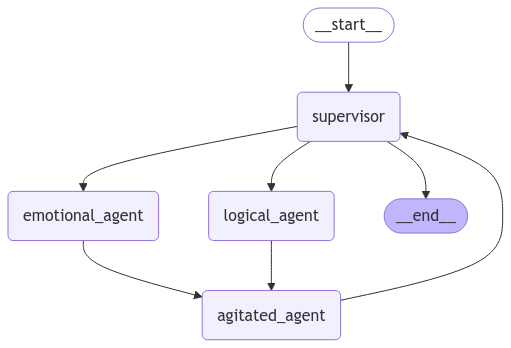

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)